In [ ]:
!pip install matplotlib

     |████████████████████████████████| 11.3 MB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 890 kB 29.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 31.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 32.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
# Class map
class_map = {
    0: 'Airplane',
    1: 'Autombile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck',
}

In [ ]:
BATCH_SIZE = 64
INPUT_SHAPE = [32, 32, 3]
EPOCHS = 30

In [ ]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
      if epoch < self.warmup_steps:
        return self.get_warmup_lr(epoch)
      if epoch <= self.max_update:
        self.base_lr = self.final_lr + (
                          self.base_lr_orig - self.final_lr) * (1 + math.cos(
                          math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

#### Load the TF record dataset

In [ ]:
## The path where the tf record file is
# file_name = '/content/drive/My Drive/public_data/cifar_10/cifar_10_data_dataset_api.tfrecords'
## Load the raw tf record file from the file system
# raw_image_dataset = tf.data.TFRecordDataset(file_name)
# print(raw_image_dataset) ## gives no much information since the parsing of a tfrecord file is not yet implemented
## To parse a tfrecord file, one needs the structure of the record file (How the data is structured when they are saved)

In [ ]:
def decode_image(image, height, width, depth):
    image = tf.io.decode_raw(image, out_type=tf.uint8)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [height, width, depth]) 
    return image

In [ ]:
## Make the structure that would help us to parse the TFRecord file
## feature descriptor dict
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [ ]:
## Now we make a function that an iterator can take as an higher oder function
def _parser_image_function(example_proto):
    ## Parse a single image feature structure
    ## serialized byte --> _parser_image_function(feature description) --> parsed image structure (see image_example function)
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    image_decoded = decode_image(example['image_raw'], 32, 32, 3)
    label = example['label']

    return image_decoded, label

In [ ]:
def load_dataset(filepath):
    # Make a dataset option object to autotune the dataloading for perfomances
    # options = tf.data.Options()
    # print(options.autotune)
    # Load the tf record dataset
    raw_image_dataset = tf.data.TFRecordDataset(filepath)
    # set the enabled option for the dataset
    # raw_image_dataset.with_options(options)
    # Parse the dataset and return
    parsed_image_dataset = raw_image_dataset.map(_parser_image_function)

    return parsed_image_dataset

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE ## Auto tune tf.data hyper parameters for 

def prepare_for_training(filepath, cache=False, shuffle_buffer_size=1000):
    ds = load_dataset(filepath)
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str): ## if caching to a file
            ds = ds.cache(cache)
        else: ## cache in memory
            ds = ds.cache()
    ## shuffle data, otherwise, data will be cached with the same patten (not random)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever (Reinitialise the dataset after each training iteration)
    # ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

2022-01-09 10:47:09.580604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:47:09.596958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:47:09.597887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:47:09.600182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 10:47:09.601100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

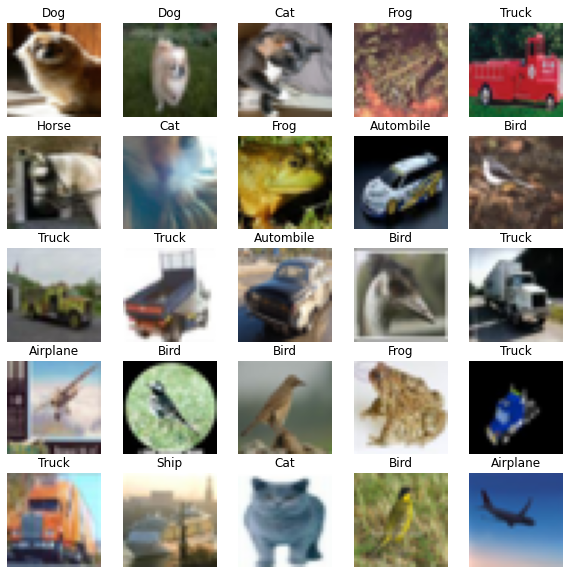

In [ ]:
# Single tfrecords
# train_ds = prepare_for_training('/content/drive/My Drive/public_data/cifar_10/train/cifar_10_data_dataset_api.tfrecords')
# Multiple tfrecords
folder_path = 'records/fs'
record_list = glob.glob(os.path.join(folder_path, '*.tfrecords'))
train_ds = prepare_for_training(record_list)
test_ds = prepare_for_training('records/fs/test_batch_from_fs.tfrecords')

image_batch, label_batch = next(iter(train_ds))

# print(image_batch[0].shape)
# plt.imshow(image_batch[1] / 255)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        # print(image_batch[n].shape)
        plt.imshow(np.uint8(image_batch[n] * 255.0))# / 255.0)
        plt.title(class_map[label_batch[n]])
        '''
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        '''
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())


In [ ]:
def make_model():
    # Resnet50 Backbone

    backbone = tf.keras.applications.vgg16.VGG16(
      include_top=False, weights='imagenet', input_tensor=None,
      input_shape=None, pooling=None
    )

    # Make a functional model
    inputs = tf.keras.layers.Input(INPUT_SHAPE)
    x = backbone(inputs)
    '''
    x = tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu')(inputs)

    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    '''
    # Classifier head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
## check if a checkpoint is available
if len(glob.glob(os.path.join('model_checkpoints', '*.h5'))) > 0:
    ## load the model
    print("Loading the model...")
    model = load_model('model_checkpoints/cifar_model.h5')
else:
    print("Building the model...")
    model = make_model()
    ## To prevent the model from becoming worst (e.g. overfitting) stop the training before the issues 
    ## start using the Early stopping callback
    # early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
    #                                                      restore_best_weights=True)

    # Checkpoint callback; A checkpoint contains the model state and optimiser state as well as the 
    # model and opitimiser graphs; suitable for continuing the training
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "model_checkpoints/cifar_model.h5", save_best_only=True
    )

    initial_learning_rate = 0.01
    scheduler = CosineScheduler(max_update=EPOCHS, base_lr=0.001, final_lr=1e-5)
    lr_schedule_cb = tf.keras.callbacks.LearningRateScheduler(
        scheduler, verbose=1
    )

    METRICS = [
        tf.keras.metrics.SparseCategoricalAccuracy(),
        #tf.keras.metrics.Precision(name='precision'),
        #tf.keras.metrics.Recall(name='recall'),
        # tf.keras.metrics.AUC(name="auc")
    ]
    model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=initial_learning_rate),
      loss="sparse_categorical_crossentropy",
      metrics=METRICS,
    )
    
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=test_ds,
    callbacks=[checkpoint_cb, lr_schedule_cb], #early_stopping_cb
)

Building the model...
58900480/58889256 [==============================] - 2s 0us/step
Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.


2022-01-09 10:47:17.601545: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


938/938 [==============================] - 88s 89ms/step - loss: 1.5648 - sparse_categorical_accuracy: 0.4384 - val_loss: 1.0831 - val_sparse_categorical_accuracy: 0.6244
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009972883382072953.
938/938 [==============================] - 82s 87ms/step - loss: 0.9324 - sparse_categorical_accuracy: 0.6743 - val_loss: 0.9016 - val_sparse_categorical_accuracy: 0.6837
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009891830623632338.
938/938 [==============================] - 83s 88ms/step - loss: 0.7765 - sparse_categorical_accuracy: 0.7296 - val_loss: 0.7046 - val_sparse_categorical_accuracy: 0.7582
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.0009757729755661011.
938/938 [==============================] - 81s 87ms/step - loss: 0.6897 - sparse_categorical_accuracy: 0.7624 - val_loss: 0.6387 - val_sparse_categorical_accuracy: 0.7790
Epoch 5/30

Epoch 00005: Learni

In [ ]:
## Save a model for inference; In contrast to checkpointing, saved_model saves a model with a MetaGraph that 
## contains the most necessary elements (model structure only) for inference
tf.saved_model.save(model, 'saved_models/vgg_cifar')

2022-01-09 11:31:49.129652: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_models/vgg_cifar/assets


In [ ]:
##